In [1]:
# imports
# data analysis and wrangling
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import preprocessing 

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelBinarizer

# Plotting
import seaborn as sns
%matplotlib inline
sns.set()

# Operating SYStem stuff
import os

In [2]:
# Get paths for data CSVs
train_path = os.path.join('data', 'train.csv')
test_path  = os.path.join('data','test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
ds = pd.concat([train_df, test_df], sort=False)

## Exploratory Data Analysis

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [27]:
#train_df.info()

### Correlations

In [7]:
# Investigate most promising ones
corr = train_df.corr()
print(corr['SalePrice'].sort_values(ascending=False))

# Keep all variables with >0.3 correlation
features = corr['SalePrice'].sort_values(ascending=False).index[0:19]
train_df = train_df[features]
test_df  = test_df[features.drop('SalePrice')]
ds = ds[features]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64


In [8]:
train_df.columns

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF'],
      dtype='object')

In [11]:
# Correlation matrix
# mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool) # create a mask

# f,ax = plt.subplots(figsize=(9,6))
# sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, mask = mask_ut)
# plt.show()

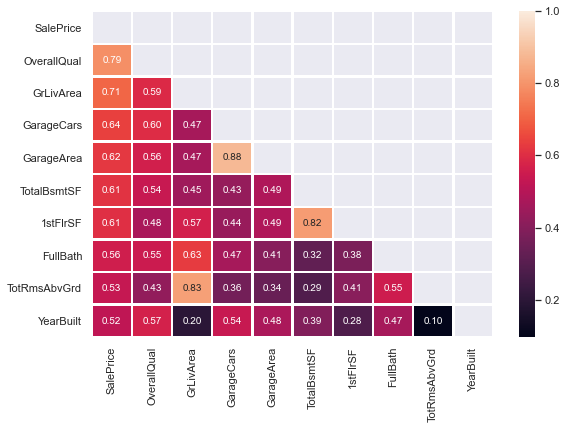

In [43]:
# Make a bit smaller corr matrix with top n most promising features
top_num = 10
corr2 = corr.loc[features[:top_num], features[:top_num]];

# Mask
mask_ut2 = np.triu(np.ones(corr2.shape)).astype(np.bool) # create a mask

# plot
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr2, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, mask = mask_ut2)
plt.show()

### Statistics of smaller train_df

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
SalePrice       1460 non-null int64
OverallQual     1460 non-null int64
GrLivArea       1460 non-null int64
GarageCars      1460 non-null int64
GarageArea      1460 non-null int64
TotalBsmtSF     1460 non-null int64
1stFlrSF        1460 non-null int64
FullBath        1460 non-null int64
TotRmsAbvGrd    1460 non-null int64
YearBuilt       1460 non-null int64
YearRemodAdd    1460 non-null int64
GarageYrBlt     1379 non-null float64
MasVnrArea      1452 non-null float64
Fireplaces      1460 non-null int64
BsmtFinSF1      1460 non-null int64
LotFrontage     1201 non-null float64
WoodDeckSF      1460 non-null int64
2ndFlrSF        1460 non-null int64
OpenPorchSF     1460 non-null int64
dtypes: float64(3), int64(16)
memory usage: 216.8 KB


In [25]:
train_df.describe()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1452.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,1.767123,472.980137,1057.429452,1162.626712,1.565068,6.517808,1971.267808,1984.865753,1978.506164,103.685262,0.613014,443.639726,70.049958,94.244521,346.992466,46.660274
std,79442.502883,1.382997,525.480383,0.747315,213.804841,438.705324,386.587738,0.550916,1.625393,30.202904,20.645407,24.689725,181.066207,0.644666,456.098091,24.284752,125.338794,436.528436,66.256028
min,34900.000000,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,2.000000,1872.000000,1950.000000,1900.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
25%,129975.000000,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000,1961.000000,0.000000,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000
50%,163000.000000,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000,1980.000000,0.000000,1.000000,383.500000,69.000000,0.000000,0.000000,25.000000
75%,214000.000000,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000,2002.000000,166.000000,1.000000,712.250000,80.000000,168.000000,728.000000,68.000000
max,755000.000000,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,14.000000,2010.000000,2010.000000,2010.000000,1600.000000,3.000000,5644.000000,313.000000,857.000000,2065.000000,547.000000


### MS Zoning

In [ ]:
"""Deprecated feature""";
#print(train_df['MSZoning'].value_counts())

In [ ]:
# encoder = LabelBinarizer()
# zoning_cat_1hot = encoder.fit_transform(ds['MSZoning'].astype(str))
# zoning_cat_1hot

In [ ]:
# np.sum(zoning_cat_1hot,axis=0)

### Overall Quality

In [35]:
# Missing values?
assert len(train_df[train_df['OverallQual'].isna()]) == 0, "Missing values present!"

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


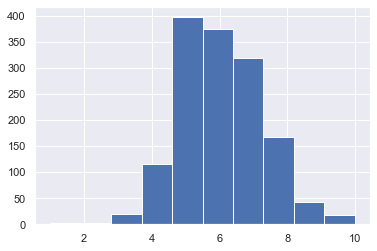

In [20]:
print(train_df['OverallQual'].value_counts());
train_df['OverallQual'].hist();

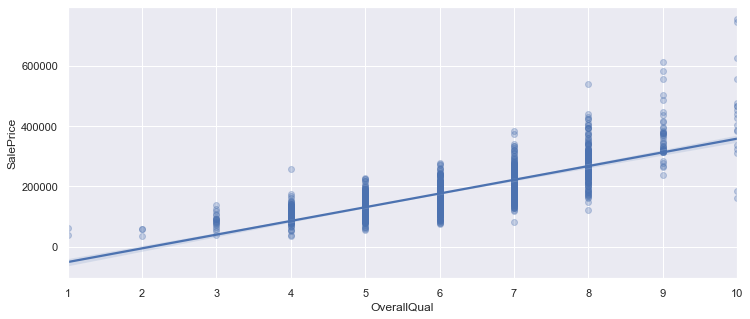

In [62]:
# Scatter between Overall Quality and SalePrice
fig = plt.figure(figsize = (12, 5))
x_qual = train_df['OverallQual']
y = train_df['SalePrice']
sns.regplot(x_qual,y, scatter_kws={'alpha':0.3})

### Above Grade Living Area (Sq. ft)

In [36]:
# Missing values?
assert len(train_df[train_df['GrLivArea'].isna()]) == 0, "Missing values present!"

In [37]:
train_df['GrLivArea'].head(15)

0     1710
1     1262
2     1786
3     1717
4     2198
5     1362
6     1694
7     2090
8     1774
9     1077
10    1040
11    2324
12     912
13    1494
14    1253
Name: GrLivArea, dtype: int64

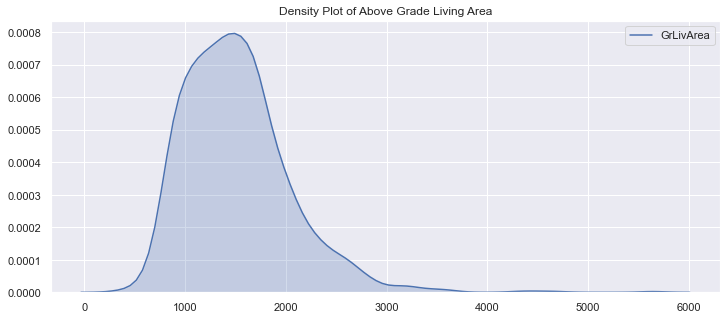

In [41]:
# Instantiate the figure and make kde plot
fig = plt.figure(figsize = (12, 5))
sns.kdeplot(train_df['GrLivArea'], shade=True)

# set the title of the plot
plt.title("Density Plot of Above Grade Living Area");

Text(0.5, 1.0, 'Scatter plot for Living Area and SalePrice')

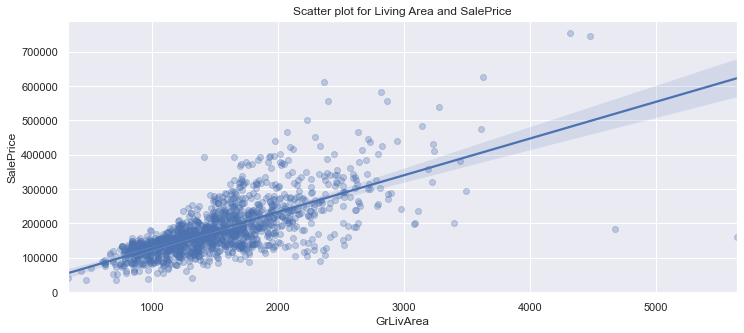

In [60]:
# Get joint distribution
x_liv = train_df['GrLivArea']

# Actual plotting
fig = plt.figure(figsize = (12, 5))
sns.regplot(x_liv, y, scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Living Area and SalePrice")

We see heteroscedasticity in both the plot for Above Grade Living Area and the Overall Quality plot. The higher the independent variable, the more variance the dependent variable shows. We can try a log transformation to potentially counteract this fanning out problem caused by heteroscedasticity.

Text(0.5, 1.0, 'Scatter plot for Living Area and Log SalePrice')

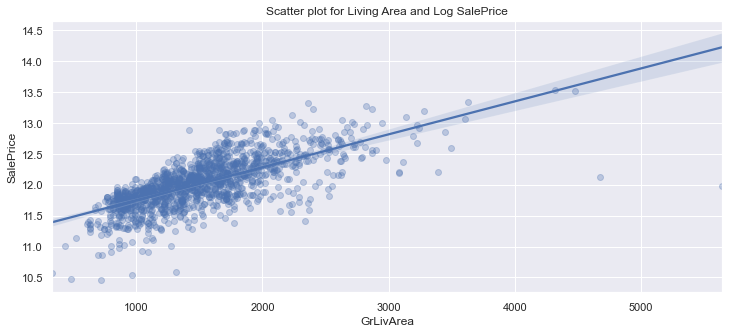

In [61]:
# Plotting the log of y instead
fig = plt.figure(figsize = (12, 5))
sns.regplot(x_liv, np.log(y), scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Living Area and Log SalePrice")

### GarageCars

In [63]:
# Missing values?
assert len(train_df[train_df['GarageCars'].isna()]) == 0, "Missing values present!"